## Library

In [51]:
import math
import random
import numpy as np
import squigglepy as sq
import matplotlib.pyplot as plt

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint

exec(open('utils.py').read())
print('Loaded')

Loaded


In [68]:
def plot_anchors(anchor1=None, anchor2=None, anchor3=None, bins=100, alpha=0.6, label1=None, label2=None, label3=None,
                verbose=True, xlim=[20, 75], figsize=(10,8)):
    if label1 is None:
        label1 = 'Anchor1'
    if label2 is None:
        label2 = 'Anchor2'
    if label3 is None:
        label3 = 'Anchor3'
        
    if anchor1 is None:
        raise ValueError
        
    if anchor2 is None and anchor3 is not None:
        raise ValueError
        
    if verbose:
        print(label1)
        pprint(sq.get_percentiles(anchor1, digits=1))
        print('-')
        if anchor2 is not None:
            print(label2)
            pprint(sq.get_percentiles(anchor2, digits=1))
            print('-')
        if anchor3 is not None:
            print(label3)
            pprint(sq.get_percentiles(anchor3, digits=1))
            print('-')
        
    plt.figure(figsize=figsize)
    plt.hist(anchor1, bins=bins, alpha=alpha, label=label1, color='black', lw=0)
    if anchor2 is not None:
        plt.hist(anchor2, bins=bins, alpha=alpha, label=label2, color='limegreen', lw=0)
    if anchor3 is not None:
        plt.hist(anchor3, bins=bins, alpha=alpha, label=label3, color='red', lw=0)
        
    plt.axvline(np.mean(anchor1), label='{} (mean)'.format(label1), color='black')
    if anchor2 is not None:
        plt.axvline(np.mean(anchor2), label='{} (mean)'.format(label2), color='green')
    if anchor3 is not None:
        plt.axvline(np.mean(anchor3), label='{} (mean)'.format(label2), color='red')
    
    plt.axvline(np.percentile(anchor1, q=10), label='{} (10% CI)'.format(label1), color='black', linestyle='--')
    if anchor2 is not None:
        plt.axvline(np.percentile(anchor2, q=10), label='{} (10% CI)'.format(label2), color='green', linestyle='--')
    if anchor3 is not None:
        plt.axvline(np.percentile(anchor3, q=10), label='{} (10% CI)'.format(label3), color='red', linestyle='--')
    
    plt.axvline(np.percentile(anchor1, q=90), label='{} (90% CI)'.format(label1), color='black', linestyle='--')
    if anchor2 is not None:
        plt.axvline(np.percentile(anchor2, q=90), label='{} (90% CI)'.format(label2), color='green', linestyle='--')
    if anchor3 is not None:
        plt.axvline(np.percentile(anchor3, q=90), label='{} (90% CI)'.format(label3), color='red', linestyle='--')
        
    plt.xlim(xlim)
    plt.legend()
    return None


def tai_log_flop_needs(brain, efficiency, transformative_vs_human, horizon_length, scaling_exponent,
                       flops_per_param_per_sec, params=None, ref_params=11.2, ref_params_samples=12,
                       bayes_update=None):
    params_ = brain + efficiency - flops_per_param_per_sec if params is None else params
    dist = ((brain + efficiency + transformative_vs_human + horizon_length + ref_params_samples) -
            (scaling_exponent * ref_params) + (scaling_exponent * params_))
    
    if bayes_update is None:
        return dist
    else:
        return sq.dist_fn(dist, bayes_update)


@np.vectorize
def cotra_bayes_update_against_low_flop(f):
    f = f + ~sq.norm(1,3) if f < 27 and random.random() > 0.3 else f
    f = f + ~sq.norm(1,3) if f < 26 and random.random() > 0.2 else f
    f = f + ~sq.norm(1,3) if f < 25 and random.random() > 0.1 else f
    f = f + ~sq.norm(1,3) if f < 24 else f
    f = 24 if f < 24 else f
    return f


def cotra_anchor(horizon_length, bayes_update=cotra_bayes_update_against_low_flop):
    return tai_log_flop_needs(brain=sq.lognorm(11,19.5),
                              efficiency=1,
                              transformative_vs_human=sq.norm(-2,2),
                              horizon_length=horizon_length,
                              scaling_exponent=sq.norm(0.5,1.1),
                              flops_per_param_per_sec=sq.norm(1,2),
                              bayes_update=bayes_update)


print('Loaded')

Loaded


## Cotra's Short NN Anchor

Anchor1
{1: 25.2,
 5: 26.4,
 10: 27.2,
 20: 28.2,
 30: 29.2,
 40: 30.4,
 50: 31.6,
 60: 32.9,
 70: 34.4,
 80: 36.1,
 90: 38.5,
 95: 40.7,
 99: 44.7}
-


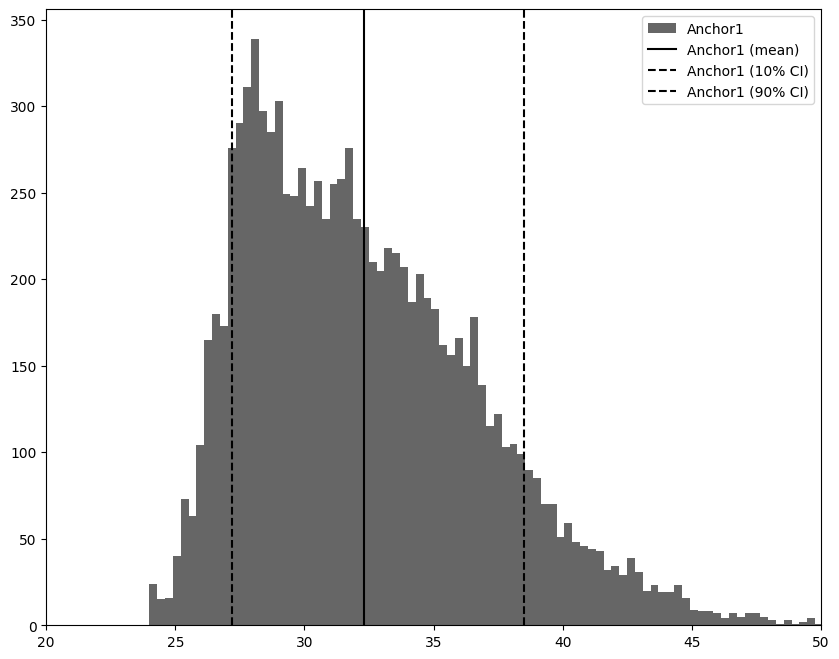

In [69]:
short_horizon_nn_anchor = cotra_anchor(horizon_length=sq.norm(0,3))
plot_anchors(short_horizon_nn_anchor @ 10000, xlim=[20, 50])

Cotra's Short NN, Before update
{1: 21.3,
 5: 24.4,
 10: 25.9,
 20: 27.8,
 30: 29.2,
 40: 30.6,
 50: 31.8,
 60: 33.0,
 70: 34.4,
 80: 36.0,
 90: 38.5,
 95: 40.4,
 99: 44.3}
-
Cotra's Short NN, After update
{1: 25.2,
 5: 26.4,
 10: 27.2,
 20: 28.2,
 30: 29.3,
 40: 30.5,
 50: 31.7,
 60: 33.0,
 70: 34.4,
 80: 35.9,
 90: 38.3,
 95: 40.2,
 99: 44.2}
-


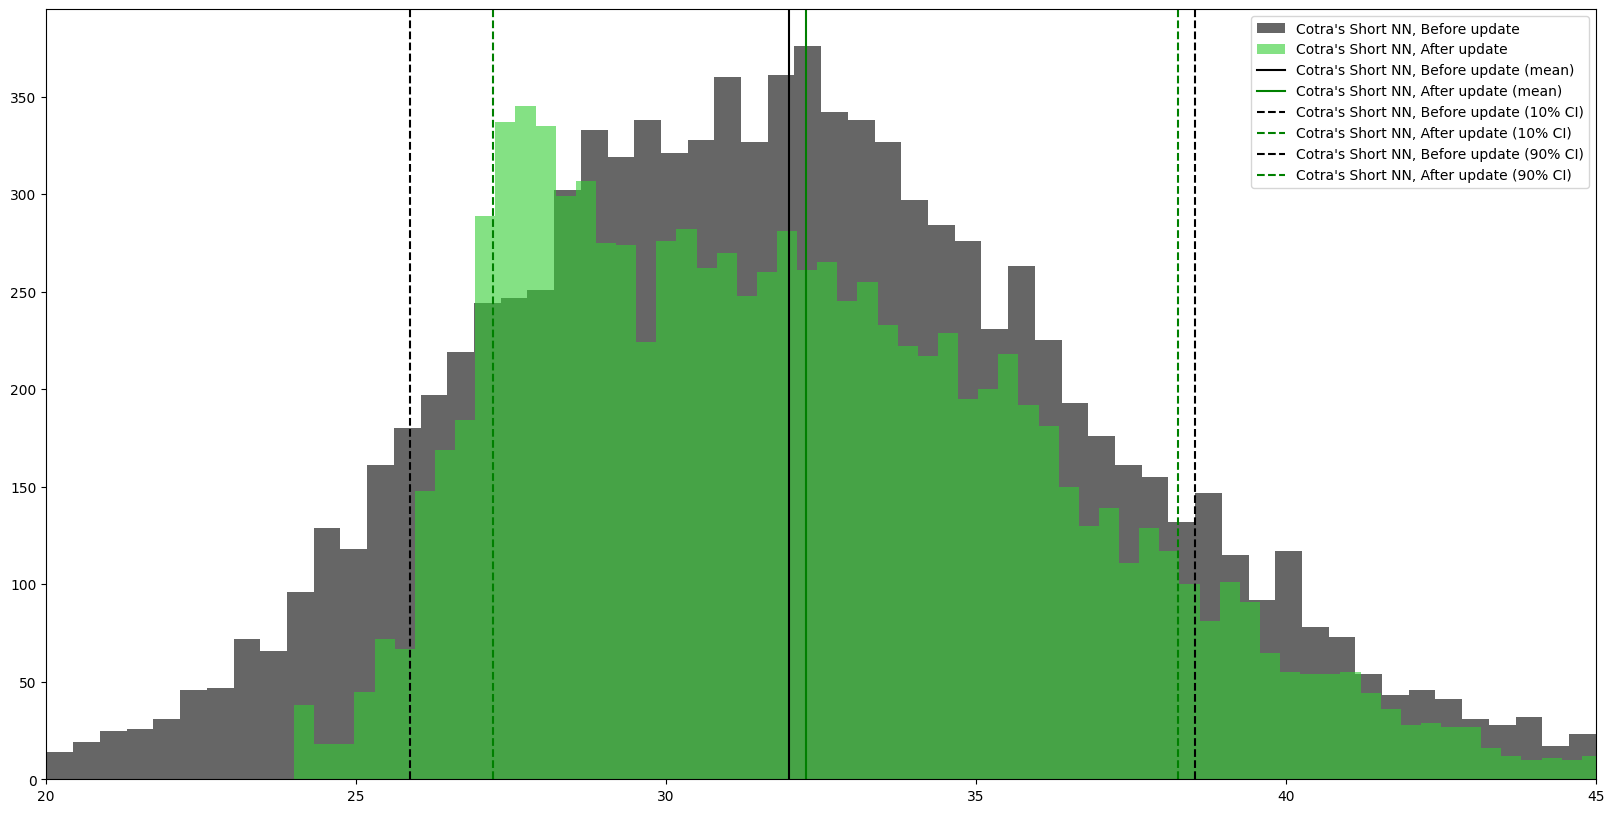

In [70]:
short_no_update = cotra_anchor(horizon_length=sq.norm(0,3), bayes_update=None)
plot_anchors(short_no_update @ 10000,
             short_horizon_nn_anchor @ 10000,
             label1='Cotra\'s Short NN, Before update',
             label2='Cotra\'s Short NN, After update',
             xlim=[20, 45],
             figsize=(20, 10))

## Cotra's Medium NN Anchor

Anchor1
{1: 26.3,
 5: 27.7,
 10: 28.7,
 20: 30.7,
 30: 32.2,
 40: 33.5,
 50: 34.7,
 60: 36.0,
 70: 37.4,
 80: 39.0,
 90: 41.5,
 95: 43.4,
 99: 47.1}
-


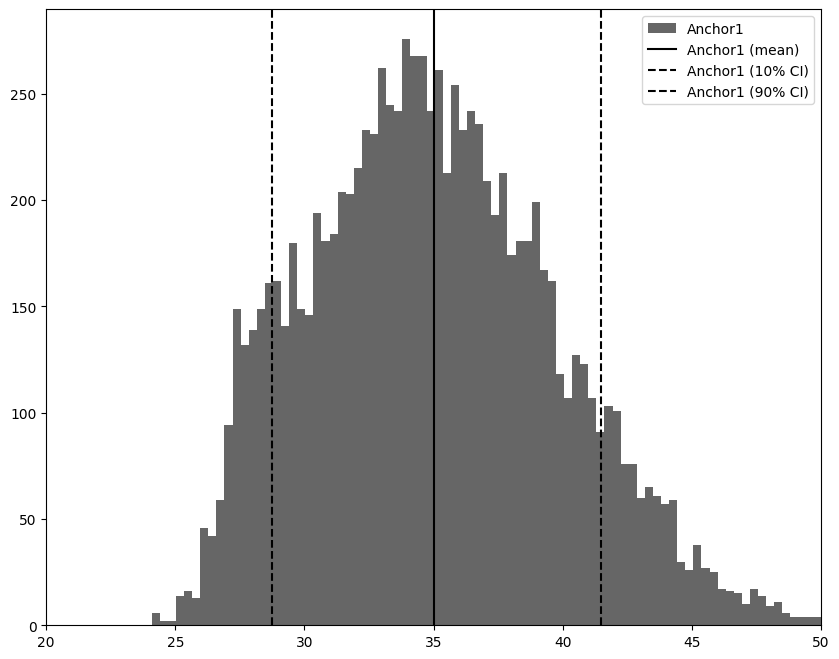

In [71]:
medium_horizon_nn_anchor = cotra_anchor(horizon_length=sq.norm(3,6))
plot_anchors(medium_horizon_nn_anchor @ 10000, xlim=[20, 50])

## Cotra's Long NN Anchor

Anchor1
{1: 27.7,
 5: 30.1,
 10: 31.7,
 20: 33.7,
 30: 35.2,
 40: 36.5,
 50: 37.8,
 60: 39.1,
 70: 40.4,
 80: 42.1,
 90: 44.4,
 95: 46.5,
 99: 50.5}
-


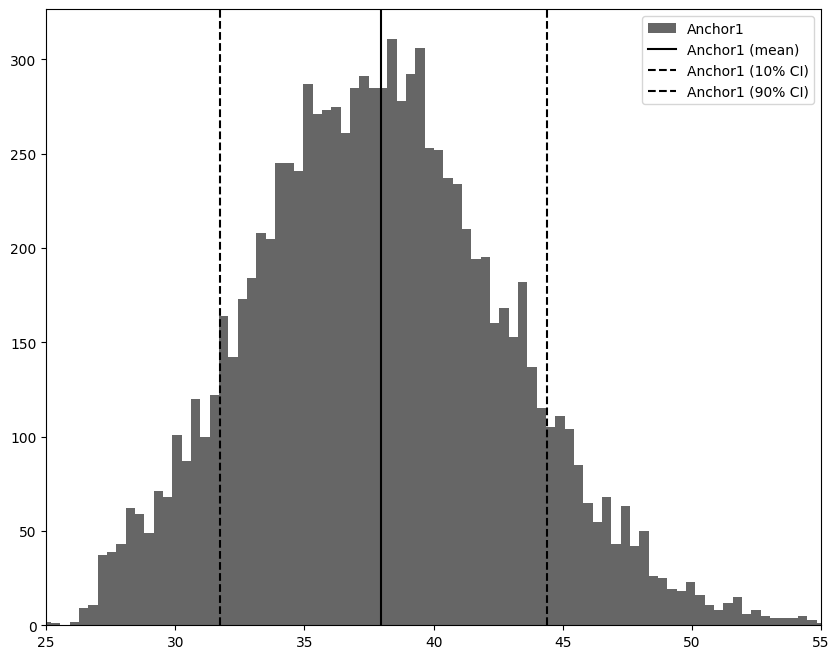

In [72]:
long_horizon_nn_anchor = cotra_anchor(horizon_length=sq.norm(6,9))
plot_anchors(long_horizon_nn_anchor @ 10000, xlim=[25, 55])

## Cotra's GPT Anchor

Anchor1
{1: 24.8,
 5: 26.0,
 10: 26.6,
 20: 27.5,
 30: 28.3,
 40: 29.1,
 50: 30.1,
 60: 31.4,
 70: 32.8,
 80: 34.4,
 90: 36.7,
 95: 38.7,
 99: 42.6}
-


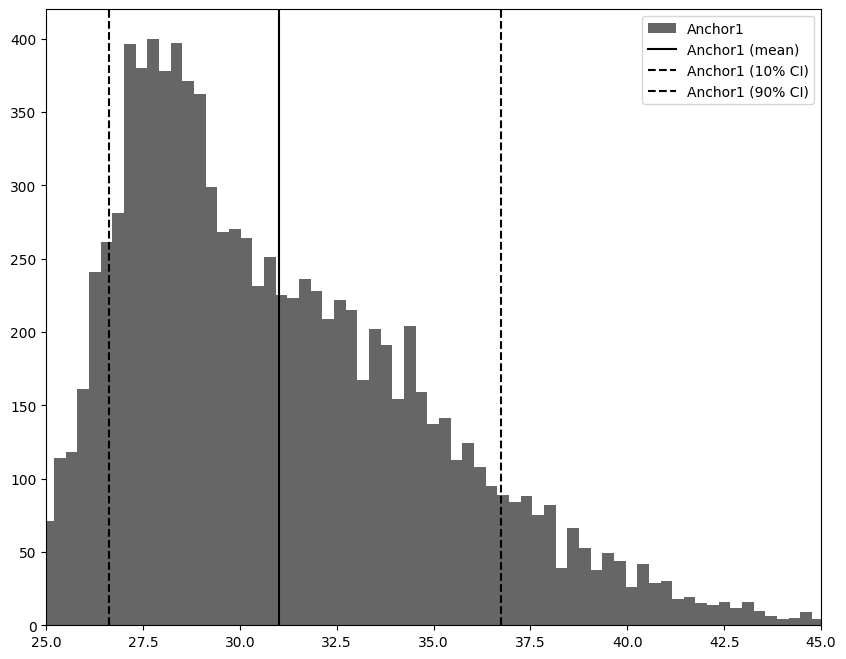

In [73]:
gpt_anchor = cotra_anchor(horizon_length=0)
plot_anchors(gpt_anchor @ 10000, xlim=[25, 45])

Cotra's GPT NN, Before update
{1: 19.8,
 5: 22.7,
 10: 24.3,
 20: 26.2,
 30: 27.7,
 40: 29.0,
 50: 30.1,
 60: 31.4,
 70: 32.8,
 80: 34.4,
 90: 36.8,
 95: 39.0,
 99: 42.8}
-
Cotra's GPT NN, After update
{1: 24.7,
 5: 26.0,
 10: 26.6,
 20: 27.5,
 30: 28.2,
 40: 29.0,
 50: 30.1,
 60: 31.3,
 70: 32.6,
 80: 34.4,
 90: 36.9,
 95: 38.9,
 99: 43.1}
-


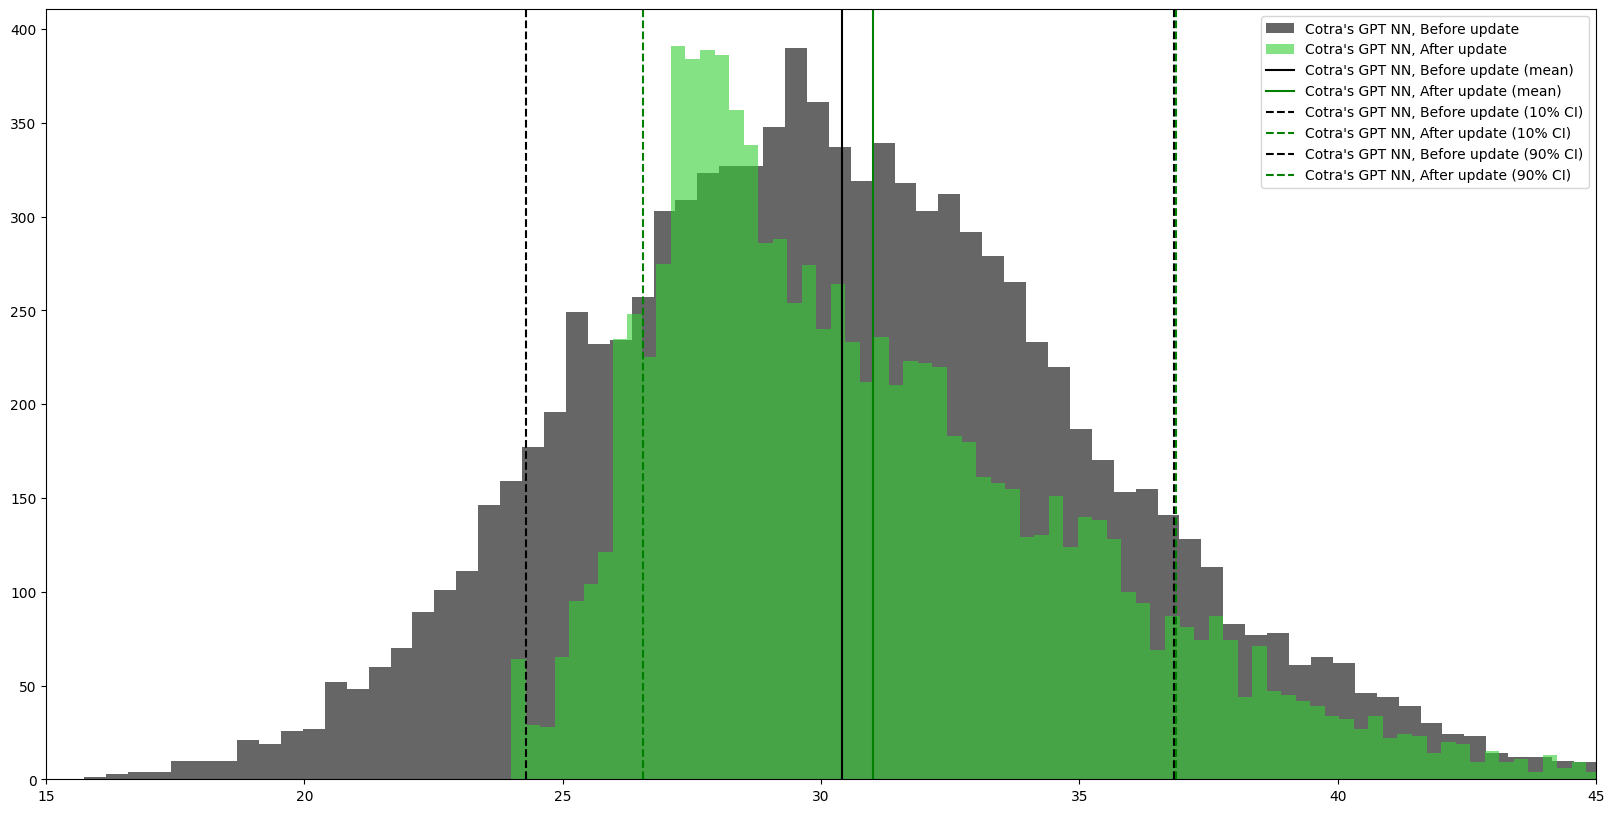

In [74]:
gpt_no_update = cotra_anchor(horizon_length=0, bayes_update=None)
plot_anchors(gpt_no_update @ 10000,
             gpt_anchor @ 10000,
             label1='Cotra\'s GPT NN, Before update',
             label2='Cotra\'s GPT NN, After update',
             xlim=[15, 45],
             figsize=(20, 10))

## Cotra's Lifetime Anchor

Anchor1
{1: 25.1,
 5: 26.1,
 10: 26.6,
 20: 27.3,
 30: 27.8,
 40: 28.3,
 50: 28.9,
 60: 29.7,
 70: 30.7,
 80: 31.9,
 90: 33.6,
 95: 35.0,
 99: 37.8}
-


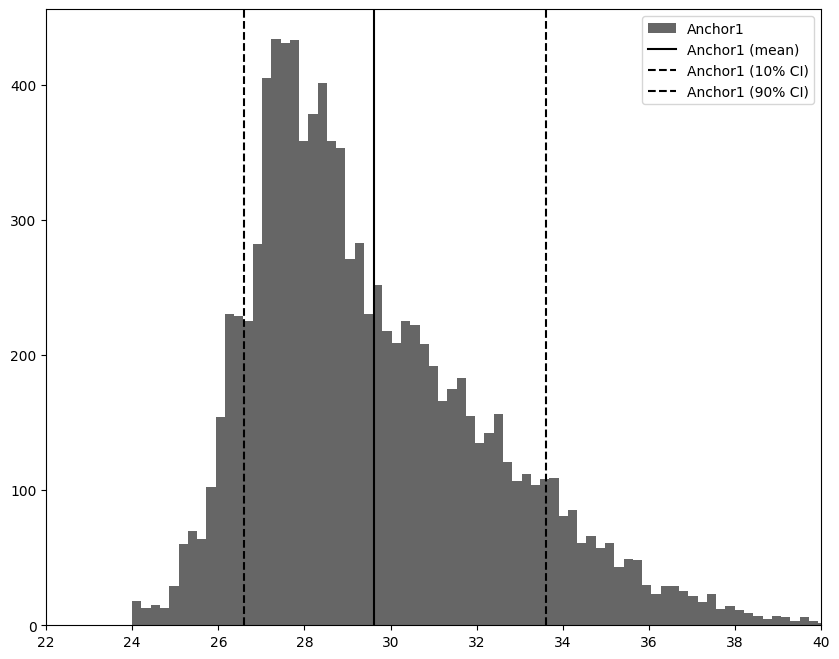

In [75]:
lifetime_anchor = tai_log_flop_needs(brain=sq.lognorm(11,19.5),
                                     efficiency=sq.mixture([sq.lognorm(2,5),
                                                            sq.lognorm(5,9)]),
                                     transformative_vs_human=sq.norm(-2,2),
                                     horizon_length=9,
                                     scaling_exponent=0,
                                     flops_per_param_per_sec=0,
                                     ref_params_samples=0,
                                     bayes_update=cotra_bayes_update_against_low_flop)
plot_anchors(lifetime_anchor @ 10000, xlim=[22, 40])

## Cotra's Evolution Anchor

Anchor1
{1: 32.5,
 5: 34.8,
 10: 36.1,
 20: 37.7,
 30: 39.0,
 40: 39.9,
 50: 40.9,
 60: 41.8,
 70: 42.9,
 80: 44.0,
 90: 45.6,
 95: 47.1,
 99: 49.5}
-


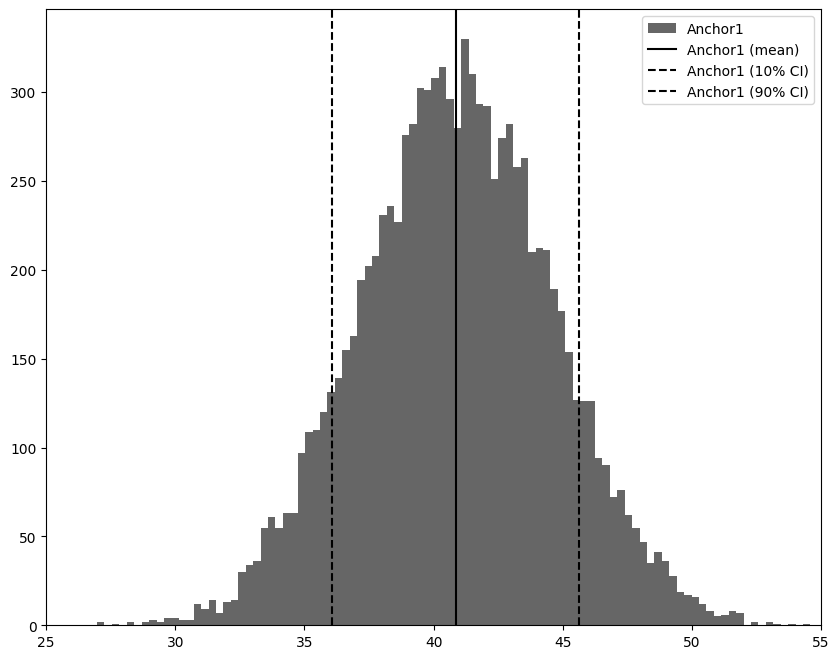

In [76]:
average_ancestor_brain_flops = sq.lognorm(3,6)
log_n_individuals = sq.norm(20,22)
evo_time_log_sec = 16
evolution_anchor = tai_log_flop_needs(brain=average_ancestor_brain_flops,
                                      efficiency=sq.norm(-6,5), # TODO: This seems not quite right
                                      transformative_vs_human=sq.norm(-2,2),
                                      horizon_length=log_n_individuals + evo_time_log_sec,
                                      scaling_exponent=0,
                                      flops_per_param_per_sec=0,
                                      ref_params_samples=0,
                                      bayes_update=None)
plot_anchors(evolution_anchor @ 10000, xlim=[25, 55])


## Cotra's Genome Anchor

Anchor1
{1: 26.6,
 5: 27.9,
 10: 29.0,
 20: 30.5,
 30: 31.7,
 40: 32.7,
 50: 33.7,
 60: 34.7,
 70: 35.8,
 80: 37.1,
 90: 39.0,
 95: 40.6,
 99: 43.3}
-


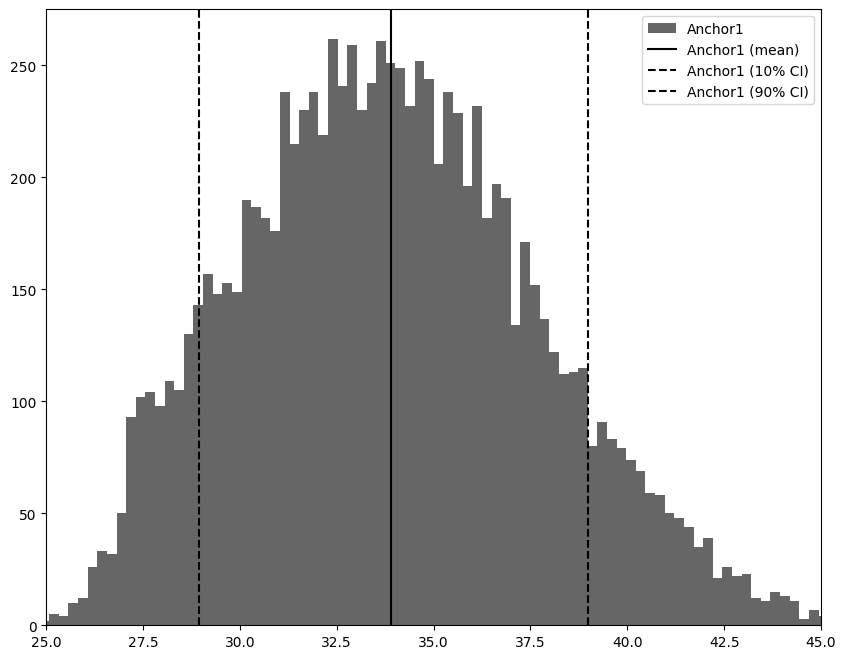

In [77]:
genome_anchor = tai_log_flop_needs(brain=sq.lognorm(11,19.5),
                                   params=sq.norm(mean=8.7, sd=0.35), # There are ~10^8.7 'params' in genome
                                   efficiency=sq.norm(0,2),
                                   transformative_vs_human=sq.norm(-2,2),
                                   horizon_length=sq.norm(7,9),
                                   scaling_exponent=sq.norm(0.5,1.1),
                                   flops_per_param_per_sec=sq.norm(1,2),
                                   bayes_update=cotra_bayes_update_against_low_flop)
plot_anchors(genome_anchor @ 10000, xlim=[25, 45])


## Simple Lifetime Anchor

Simple lifetime, before update
{1: 18.7,
 5: 20.0,
 10: 20.8,
 20: 21.7,
 30: 22.4,
 40: 23.0,
 50: 23.6,
 60: 24.3,
 70: 25.1,
 80: 25.9,
 90: 27.3,
 95: 28.4,
 99: 30.9}
-
Simple lifetime, after update
{1: 24.0,
 5: 24.6,
 10: 25.1,
 20: 25.6,
 30: 26.0,
 40: 26.3,
 50: 26.6,
 60: 27.0,
 70: 27.3,
 80: 27.8,
 90: 28.4,
 95: 29.0,
 99: 31.0}
-
Cotra's lifetime anchor
{1: 25.1,
 5: 26.0,
 10: 26.6,
 20: 27.3,
 30: 27.8,
 40: 28.3,
 50: 28.9,
 60: 29.7,
 70: 30.7,
 80: 31.9,
 90: 33.6,
 95: 35.1,
 99: 38.0}
-


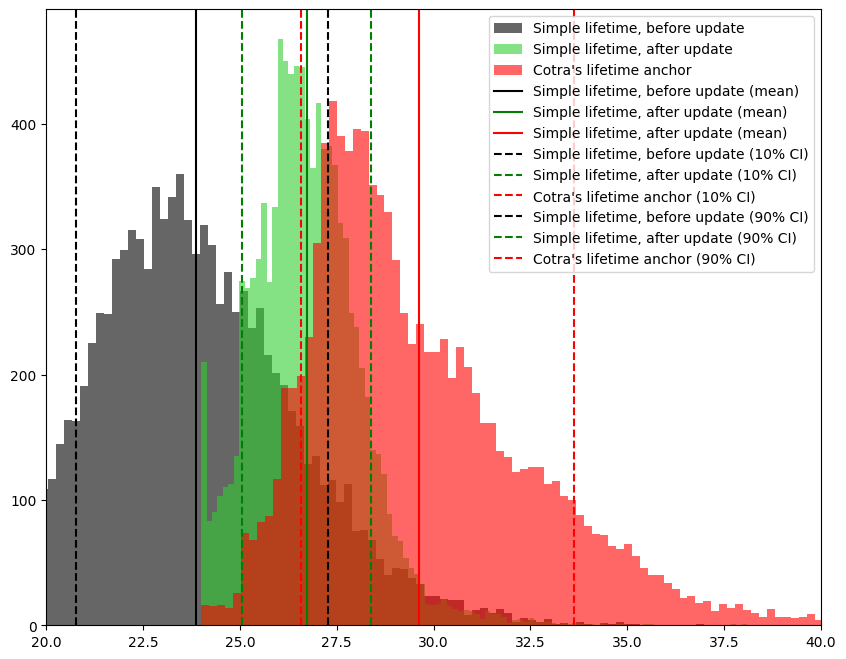

In [78]:
simple_lifetime_anchor = tai_log_flop_needs(brain=sq.lognorm(11,19.5),
                                            efficiency=0,
                                            transformative_vs_human=0,
                                            horizon_length=9,
                                            scaling_exponent=0,
                                            flops_per_param_per_sec=0,
                                            ref_params_samples=0,
                                            bayes_update=cotra_bayes_update_against_low_flop)

simple_lifetime_anchor_noup = tai_log_flop_needs(brain=sq.lognorm(11,19.5),
                                                 efficiency=0,
                                                 transformative_vs_human=0,
                                                 horizon_length=9,
                                                 scaling_exponent=0,
                                                 flops_per_param_per_sec=0,
                                                 ref_params_samples=0,
                                                 bayes_update=None)

plot_anchors(simple_lifetime_anchor_noup @ 10000,
             simple_lifetime_anchor @ 10000,
             lifetime_anchor @ 10000,
             label1='Simple lifetime, before update',
             label2='Simple lifetime, after update',
             label3='Cotra\'s lifetime anchor',
             xlim=[20,40])


## Updated Evolution Anchor

Cotra's evolution anchor
{1: 32.2,
 5: 34.7,
 10: 36.1,
 20: 37.7,
 30: 38.9,
 40: 39.9,
 50: 40.8,
 60: 41.8,
 70: 42.8,
 80: 44.0,
 90: 45.6,
 95: 47.0,
 99: 49.4}
-
Updated evolution anchor
{1: 32.2,
 5: 34.9,
 10: 36.3,
 20: 38.0,
 30: 39.3,
 40: 40.4,
 50: 41.3,
 60: 42.3,
 70: 43.3,
 80: 44.6,
 90: 46.4,
 95: 48.0,
 99: 50.8}
-


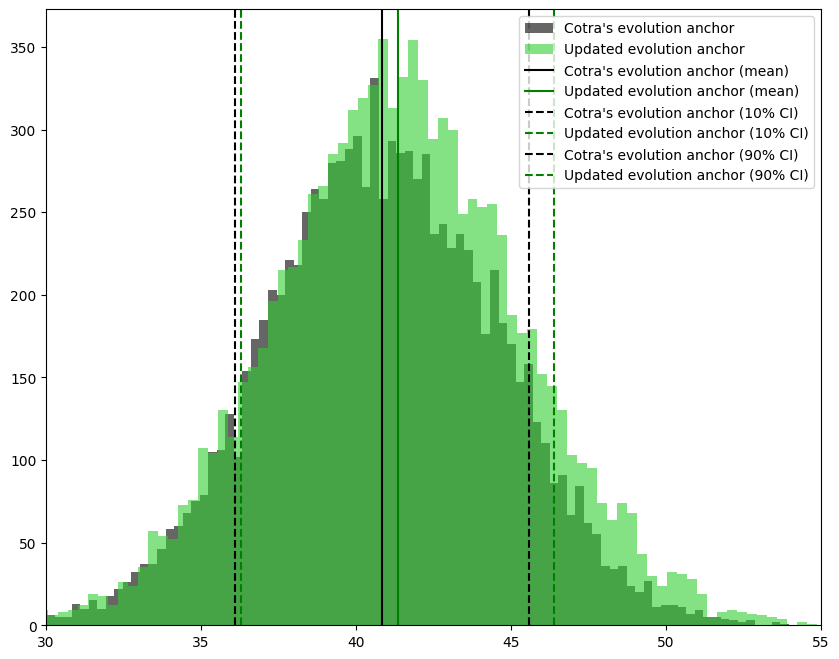

In [81]:
anthropic_adjustment = sq.norm(-1.3,1.3)
environment_adjustment = sq.mixture([[0.2, sq.lognorm(1,5)], [0.8, 0]])    
updated_evolution_anchor = evolution_anchor + anthropic_adjustment + environment_adjustment

plot_anchors(evolution_anchor @ 10000,
             updated_evolution_anchor @ 10000,
             label1='Cotra\'s evolution anchor',
             label2='Updated evolution anchor',
             xlim=[30, 55])


## Meta-anchor

### Horizon length

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 38340.04it/s]


Writing cache to file `caches/meta_anchor.sqcache.npy`...
...Cached
Anchor1
{1: 19.1,
 5: 23.9,
 10: 25.2,
 20: 26.8,
 30: 28.7,
 40: 30.5,
 50: 32.4,
 60: 34.4,
 70: 36.5,
 80: 39.1,
 90: 42.6,
 95: 45.8,
 99: 52.4}
-


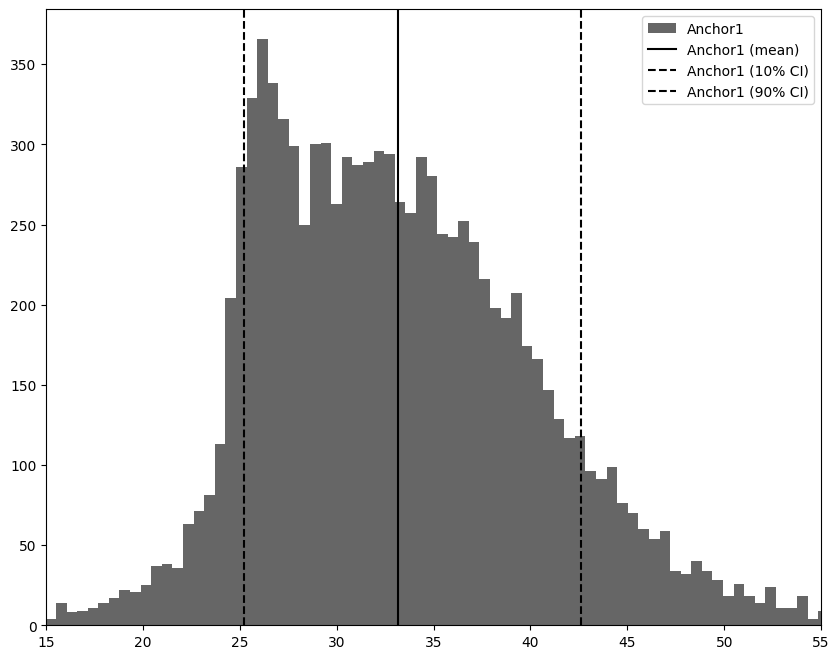

In [85]:
@np.vectorize
def peter_bayes_update_against_low_flop(f):
    f = f + sq.sample(sq.norm(1,3)) if f < 27 and random.random() > 0.9 else f
    f = f + sq.sample(sq.norm(1,3)) if f < 26 and random.random() > 0.8 else f
    f = f + sq.sample(sq.norm(1,3)) if f < 25 and random.random() > 0.4 else f
    f = f + sq.sample(sq.norm(1,3)) if f < 24 and random.random() > 0.1 else f
    return f

meta_horizon_length = sq.mixture([[0.4, 0],
                                  [0.2, sq.norm(0,3)],
                                  [0.25, sq.lognorm(3,7)],
                                  [0.15, sq.norm(7,11)]], lclip=0)

meta_anchor = tai_log_flop_needs(brain=sq.lognorm(11,19.5),
                                 efficiency=sq.norm(-1,2),
                                 transformative_vs_human=sq.norm(-2,2),
                                 horizon_length=meta_horizon_length,
                                 scaling_exponent=sq.norm(0.5,1.5),
                                 flops_per_param_per_sec=sq.norm(1,2),
                                 bayes_update=peter_bayes_update_against_low_flop)
meta_anchor_samples = sq.sample(meta_anchor, dump_cache_file='caches/meta_anchor', n=10000, verbose=True)
plot_anchors(meta_anchor_samples, xlim=[15,55])


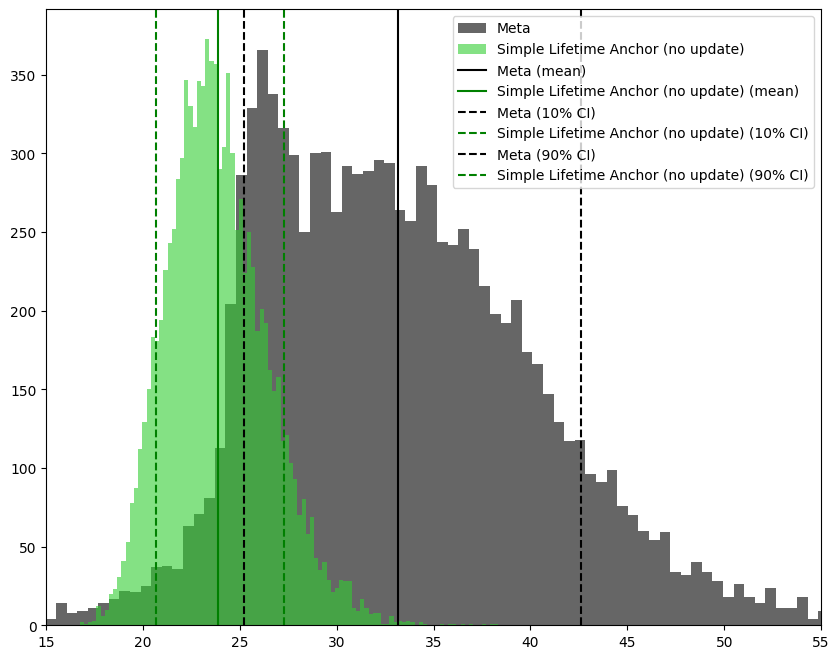

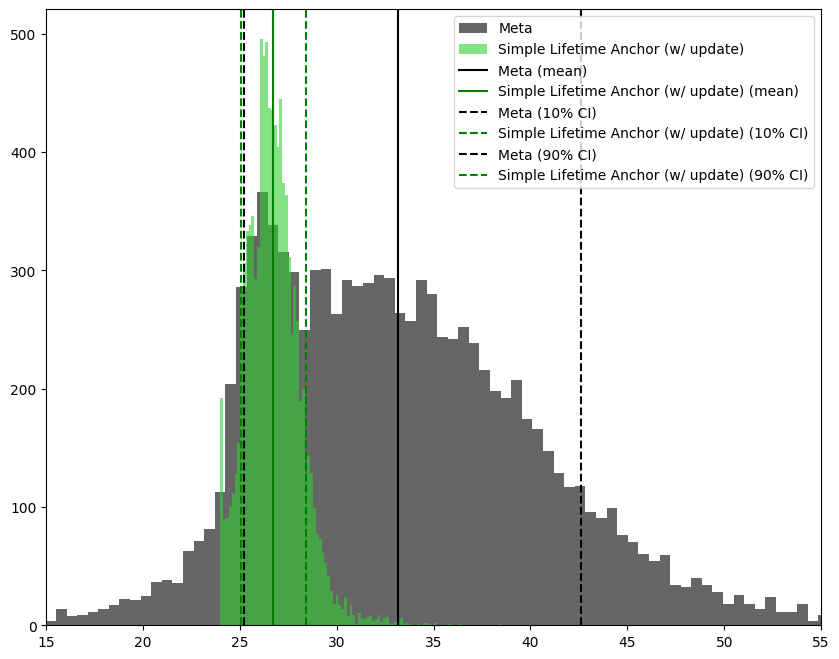

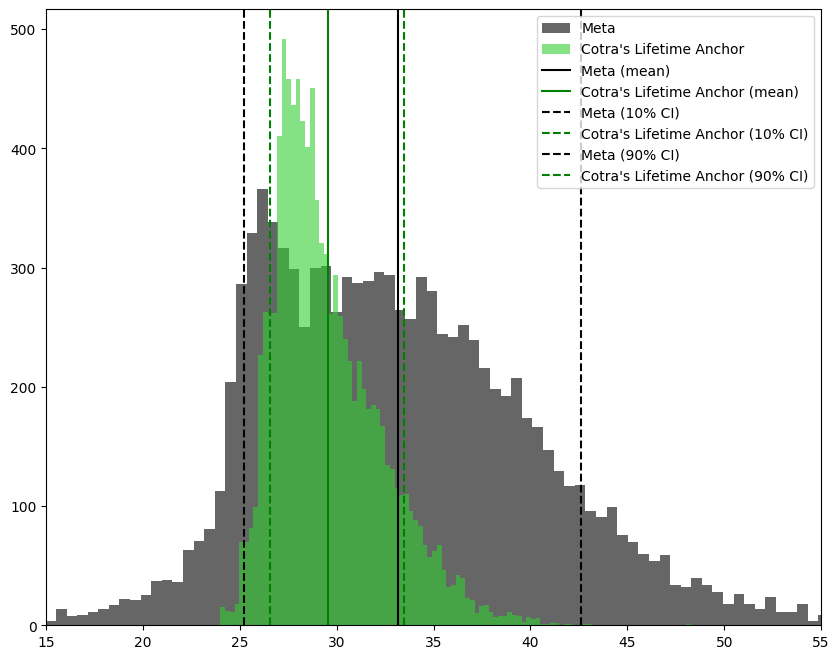

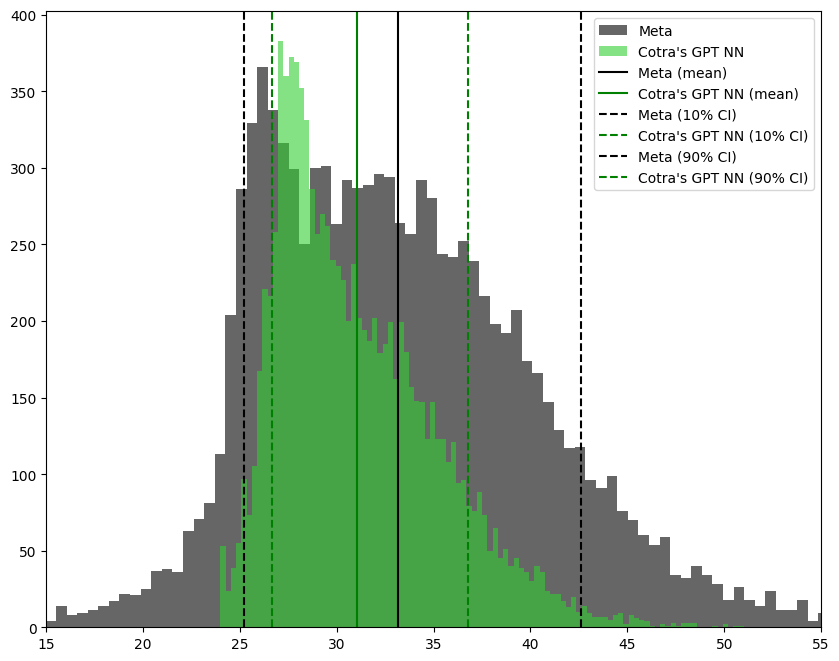

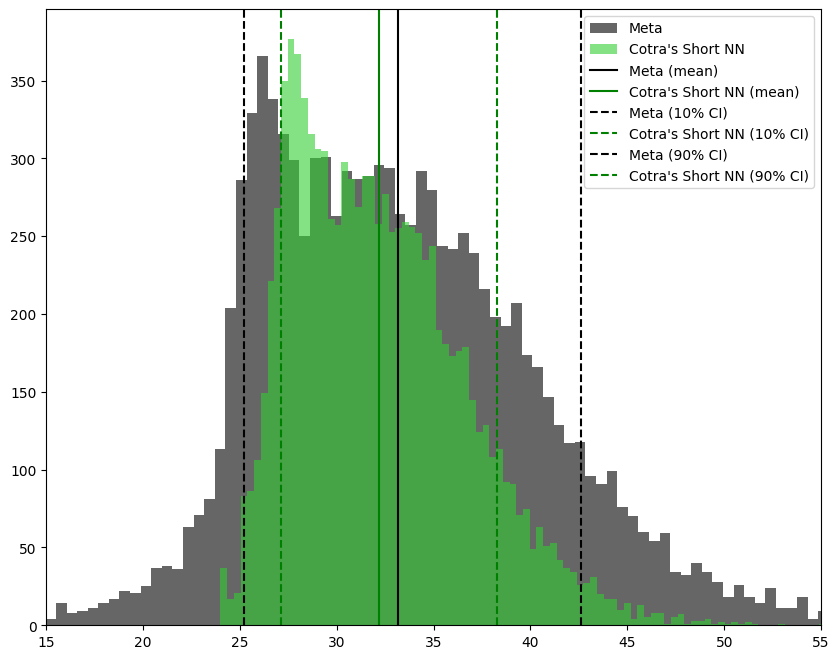

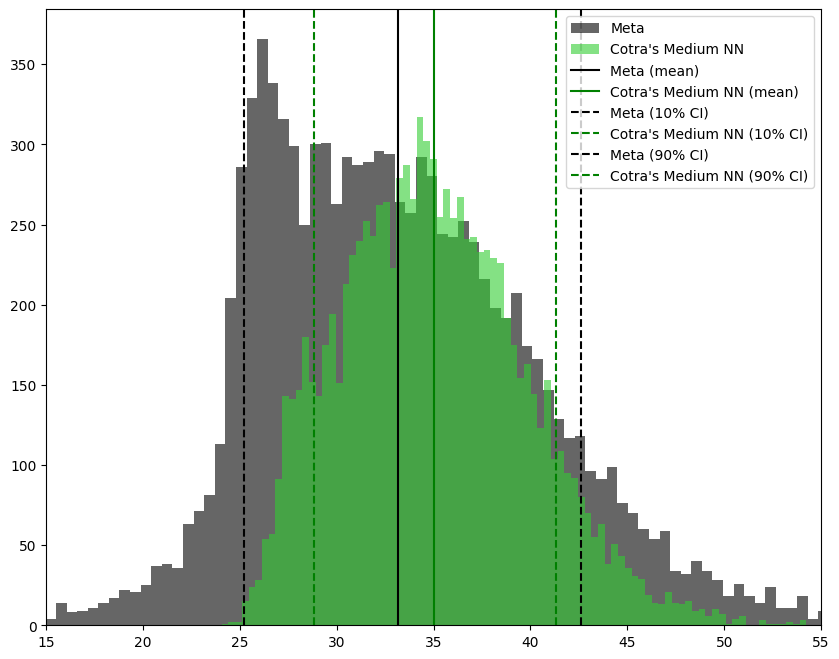

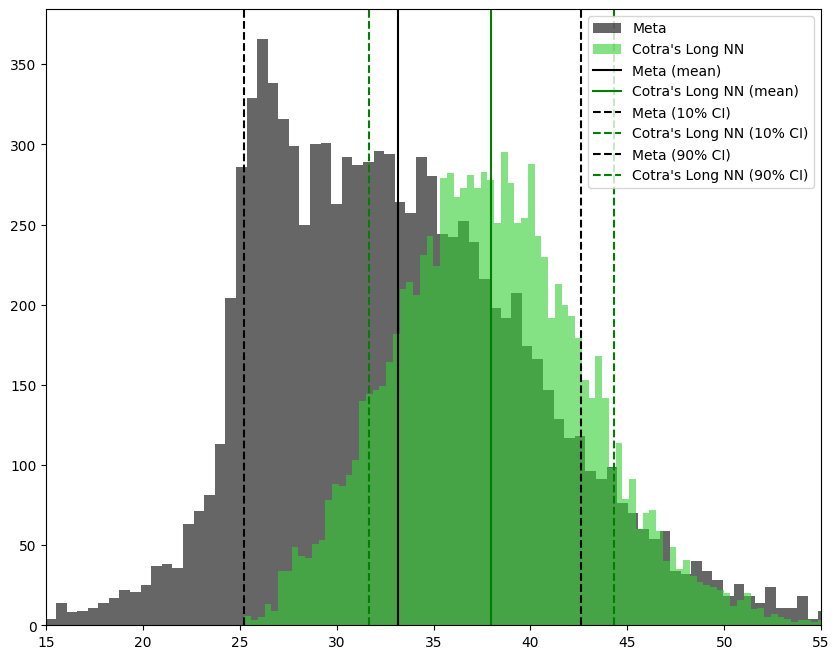

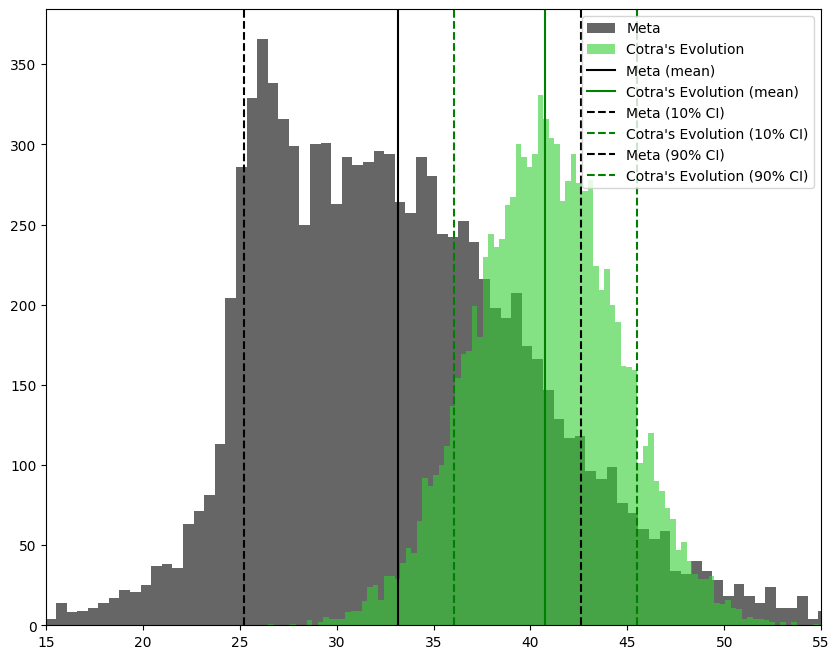

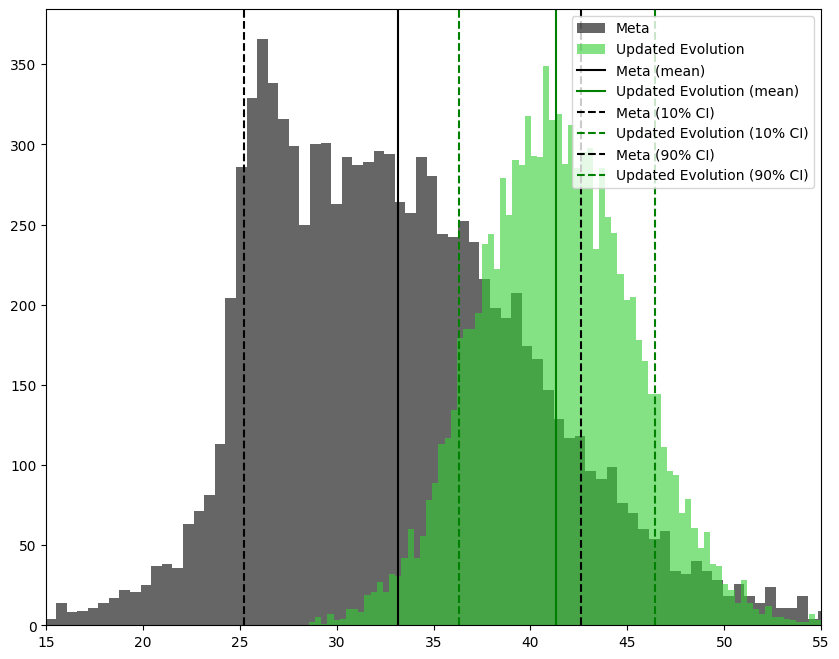

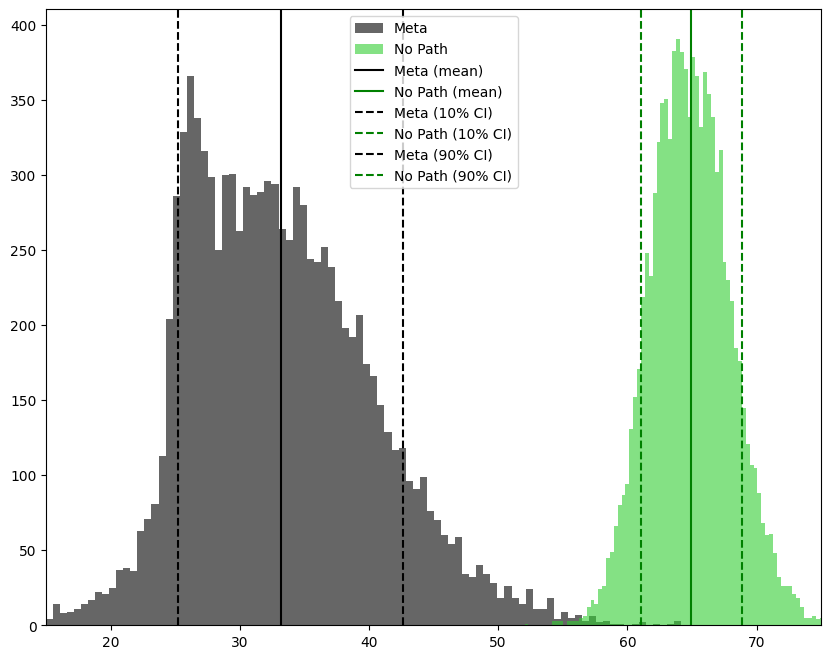

In [86]:
no_path_anchor = sq.lognorm(60,70)

for anchors in [[simple_lifetime_anchor_noup @ 10000, 'Simple Lifetime Anchor (no update)'],
                [simple_lifetime_anchor @ 10000, 'Simple Lifetime Anchor (w/ update)'],
                [lifetime_anchor @ 10000, 'Cotra\'s Lifetime Anchor'],
                [gpt_anchor @ 10000, 'Cotra\'s GPT NN'],
                [short_horizon_nn_anchor @ 10000, 'Cotra\'s Short NN'],
                [medium_horizon_nn_anchor @ 10000, 'Cotra\'s Medium NN'],
                [long_horizon_nn_anchor @ 10000, 'Cotra\'s Long NN'],
                [evolution_anchor @ 10000, 'Cotra\'s Evolution'],
                [updated_evolution_anchor @ 10000, 'Updated Evolution'],
                [no_path_anchor @ 10000, 'No Path']]:
    plot_anchors(meta_anchor_samples,
                 anchors[0],
                 label1='Meta',
                 label2=anchors[1],
                 xlim=[15, 75 if anchors[1] == 'No Path' else 55],
                 verbose=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1598.10it/s]


Writing cache to file `caches/cotra_2020.sqcache.npy`...
...Cached
Anchor1
{1: 26.0,
 5: 27.4,
 10: 28.4,
 20: 30.4,
 30: 32.2,
 40: 33.8,
 50: 35.4,
 60: 37.0,
 70: 38.8,
 80: 41.1,
 90: 45.1,
 95: 62.8,
 99: 68.1}
-


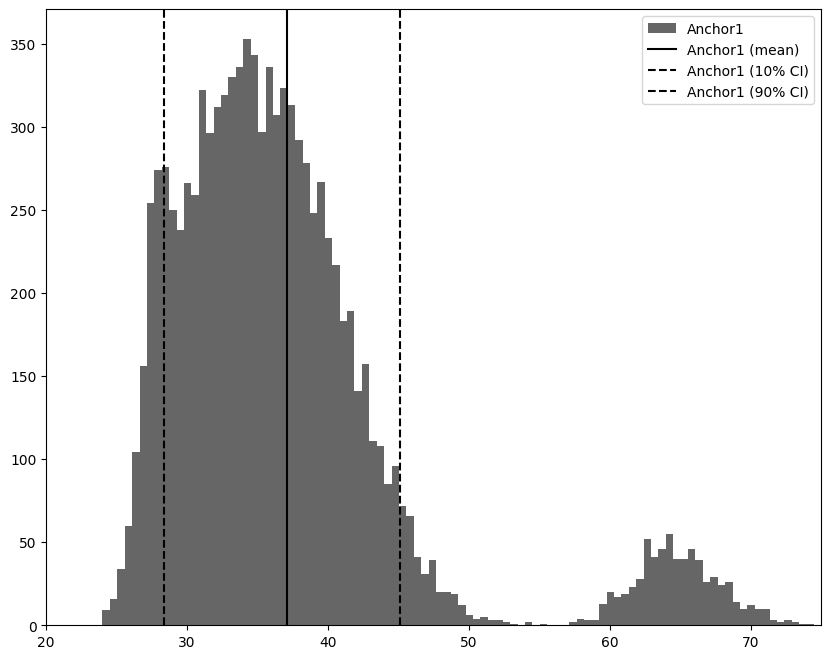

In [87]:
cotra_2020 = sq.mixture([[0.052, lifetime_anchor],
                         [0.21, short_horizon_nn_anchor],
                         [0.11, genome_anchor],
                         [0.312, medium_horizon_nn_anchor],
                         [0.155, long_horizon_nn_anchor],
                         [0.091, evolution_anchor],
                         [0.07, no_path_anchor]])
cotra_2020_samples = sq.sample(cotra_2020, dump_cache_file='caches/cotra_2020', n=10000, verbose=True)
plot_anchors(cotra_2020_samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1535.89it/s]


Writing cache to file `caches/cotra_2022.sqcache.npy`...
...Cached
Anchor1
{1: 25.7,
 5: 27.0,
 10: 27.8,
 20: 29.3,
 30: 31.0,
 40: 32.4,
 50: 33.9,
 60: 35.4,
 70: 37.0,
 80: 39.2,
 90: 42.9,
 95: 60.0,
 99: 67.3}
-


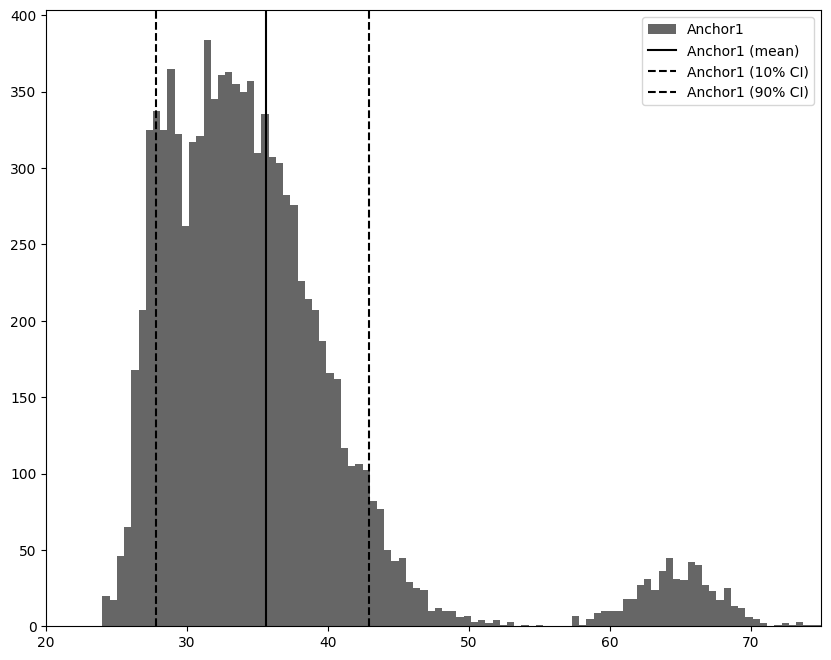

In [88]:
cotra_2022 = sq.mixture([[0.1, gpt_anchor],
                         [0.33, short_horizon_nn_anchor],
                         [0.09, genome_anchor],
                         [0.34, medium_horizon_nn_anchor],
                         [0.04, long_horizon_nn_anchor],
                         [0.05, evolution_anchor],
                         [0.05, no_path_anchor]])
cotra_2022_samples = sq.sample(cotra_2022, dump_cache_file='caches/cotra_2022', n=10000, verbose=True)
plot_anchors(cotra_2022_samples)


Cotra 2020
{1: 26.0,
 5: 27.4,
 10: 28.4,
 20: 30.4,
 30: 32.2,
 40: 33.8,
 50: 35.4,
 60: 37.0,
 70: 38.8,
 80: 41.1,
 90: 45.1,
 95: 62.8,
 99: 68.1}
-
Cotra 2022
{1: 25.7,
 5: 27.0,
 10: 27.8,
 20: 29.3,
 30: 31.0,
 40: 32.4,
 50: 33.9,
 60: 35.4,
 70: 37.0,
 80: 39.2,
 90: 42.9,
 95: 60.0,
 99: 67.3}
-


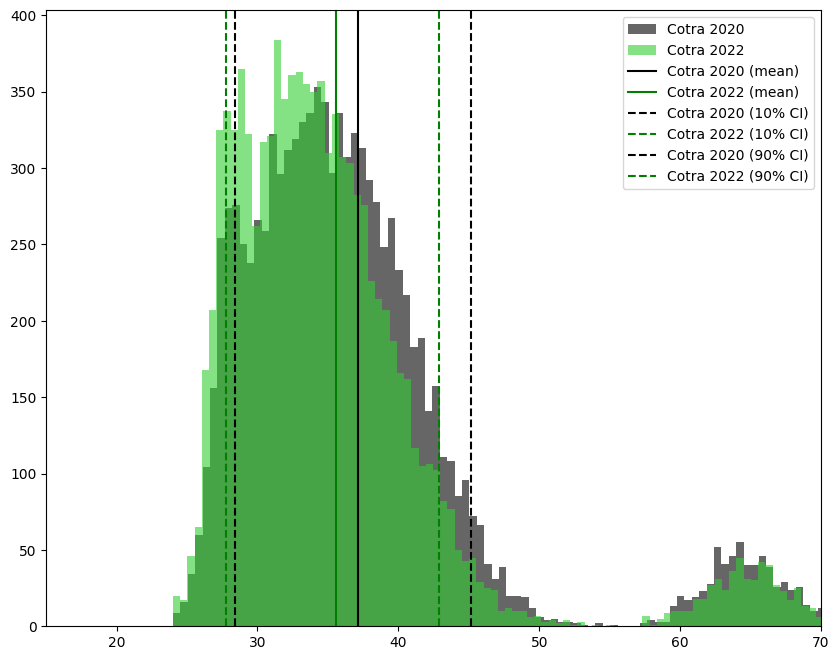

In [92]:
plot_anchors(cotra_2020_samples,
             cotra_2022_samples,
             label1='Cotra 2020',
             label2='Cotra 2022',
             xlim=[15,70])

Meta
{1: 19.1,
 5: 23.9,
 10: 25.2,
 20: 26.8,
 30: 28.7,
 40: 30.5,
 50: 32.4,
 60: 34.4,
 70: 36.5,
 80: 39.1,
 90: 42.6,
 95: 45.8,
 99: 52.4}
-
Cotra 2020
{1: 26.0,
 5: 27.4,
 10: 28.4,
 20: 30.4,
 30: 32.2,
 40: 33.8,
 50: 35.4,
 60: 37.0,
 70: 38.8,
 80: 41.1,
 90: 45.1,
 95: 62.8,
 99: 68.1}
-


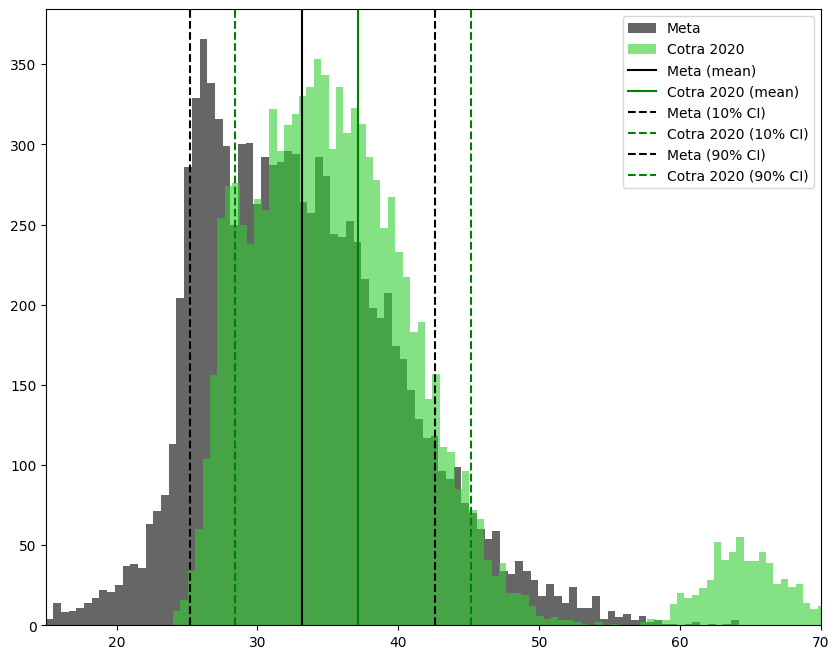

In [93]:
plot_anchors(meta_anchor_samples,
             cotra_2020_samples,
             label1='Meta',
             label2='Cotra 2020',
             xlim=[15,70])

Meta
{1: 19.1,
 5: 23.9,
 10: 25.2,
 20: 26.8,
 30: 28.7,
 40: 30.5,
 50: 32.4,
 60: 34.4,
 70: 36.5,
 80: 39.1,
 90: 42.6,
 95: 45.8,
 99: 52.4}
-
Cotra 2022
{1: 25.7,
 5: 27.0,
 10: 27.8,
 20: 29.3,
 30: 31.0,
 40: 32.4,
 50: 33.9,
 60: 35.4,
 70: 37.0,
 80: 39.2,
 90: 42.9,
 95: 60.0,
 99: 67.3}
-


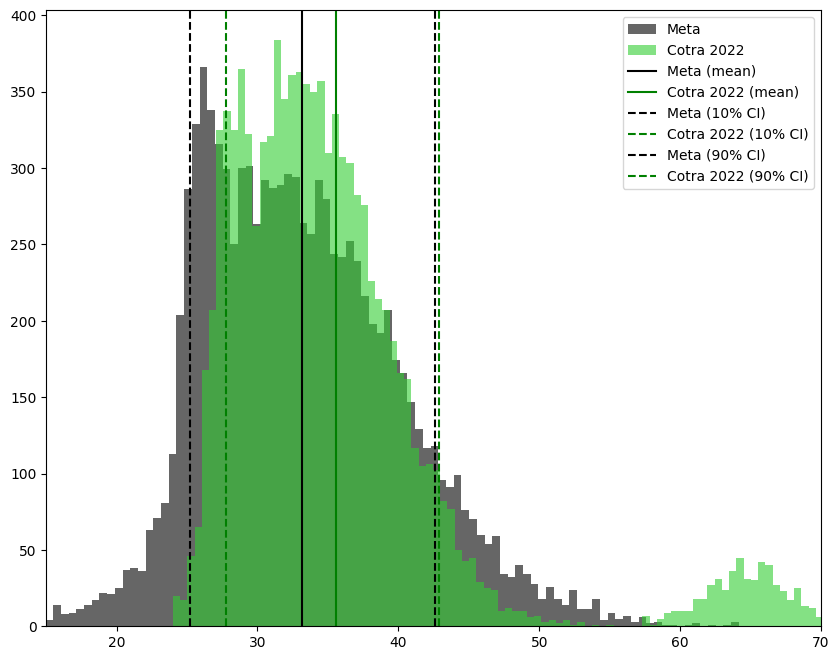

In [94]:
plot_anchors(meta_anchor_samples,
             cotra_2022_samples,
             label1='Meta',
             label2='Cotra 2022',
             xlim=[15,70])